In [1]:
import abc

In [2]:
import numpy as np

In [3]:
np.seterr(all='raise', under='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

---

activation function

In [6]:
class ActivationFunction(abc.ABC):
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def apply(self, v):
        pass
    
    @abc.abstractmethod
    def derivative(self, v, activated_value):
        pass

In [7]:
class ActivationNone(ActivationFunction):
    def __init__(self):
        pass
    
    def apply(self, v):
        return v
    
    def derivative(self, v, activated_value=True):
        return 1

In [189]:
class ActivationSigmoid(ActivationFunction):
    def __init__(self, x_upper_bound=None, x_lower_bound=None):
        self.x_upper_bound = x_upper_bound
        self.x_lower_bound = x_lower_bound
    
    def apply(self, v):
        if self.x_upper_bound or self.x_upper_bound:
            return 1.0 / (1.0 + np.exp(-v.clip(max=self.x_upper_bound, min=self.x_lower_bound)))
        return 1.0 / (1.0 + np.exp(-v))
    
    def derivative(self, v, activated_value=True):
        if not activated_value:
            v = self.apply(v)
        return v * (1 - v)

In [9]:
class ActivationRelu(ActivationFunction):
    def __init__(self):
        pass
    
    def apply(self, v):
        return v.clip(min=0)
    
    def derivative(self, v, activated_value=True):
        if not activated_value:
            v = self.apply(v)
        return np.where(v>0,1,0)

---

gd optimizer

In [10]:
class GDOptimizer(abc.ABC):
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def accelerate(self, grads, intercept_grads):
        pass

In [11]:
class GDOptimizerNone(GDOptimizer):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    def accelerate(self, grads, intercept_grads):
        weight_deltas = [learning_rate * grad for grad in grads]
        intercept_deltas = [learning_rate * grad for grad in intercept_grads]
        return weight_deltas, intercept_deltas

In [202]:
class GDOptimizerMomentum(GDOptimizer):
    def __init__(self, learning_rate, gamma=0.9):
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.last_weight_deltas = None
        self.last_intercept_deltas = None
    
    def accelerate(self, grads, intercept_grads):
        self.last_weight_deltas = \
            [(self.gamma*self.last_weight_deltas[i] if self.last_weight_deltas is not None else 0)
             + self.learning_rate*grads[i] for i in range(len(grads))]
        self.last_intercept_deltas = \
            [(self.gamma*self.last_intercept_deltas[i] if self.last_intercept_deltas is not None else 0)
             + self.learning_rate*intercept_grads[i] for i in range(len(intercept_grads))]
        return self.last_weight_deltas, self.last_intercept_deltas

In [13]:
class GDOptimizerAdagrad(GDOptimizer):
    def __init__(self, learning_rate=0.01, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
        

In [14]:
class GDOptimizerAdadelta(GDOptimizer):
    def __init__(self, gamma=0.9, epsilon=1e-8):
        self.gamma = gamma
        self.epsilon = epsilon
        
        

In [15]:
class GDOptimizerRMSprop(GDOptimizer):
    def __init__(self, learning_rate=0.001, gamma=0.9, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        

---

nn model

In [141]:
class NNLayer:
    def __init__(self, node_count, activation):
        self.node_count = node_count
        self.activation = activation
        self.weights = None
        self.intercepts = None
    
    def init_weights(self, prev_node_count, has_intercepts):
        self.weights, self.intercepts = self.xavier_weight_init(prev_node_count, self.node_count, has_intercepts)
        
    def update_weights(self, weight_deltas, intercept_deltas):
        self.weights -= weight_deltas
        self.intercepts -= intercept_deltas
    
    def xavier_weight_init(self, prev_node_count, cur_node_count, has_intercepts):
        weights = np.random.randn(prev_node_count, cur_node_count)/np.sqrt(prev_node_count)
        intercepts = np.random.randn(cur_node_count)/np.sqrt(prev_node_count) \
            if has_intercepts else np.zeros(cur_node_count)
        return weights, intercepts

In [142]:
class NNModel:
    def __init__(self, X_size, layers, gd_optimizer, has_interception=True):
        self.X_size = X_size
        self.has_interception = has_interception
        self.model = layers
        self.gd_optimizer = gd_optimizer
        self.hidden_layer_res = []
        self.init_model()
    
    # initialize model with layers
    def init_model(self):
        prev_node_count = self.X_size
        for layer in self.model:
            layer.init_weights(prev_node_count, self.has_interception)
            prev_node_count = layer.node_count
    
    # forward pass, calculate predict value with current model (batch or single)
    def model_forward(self, X):
        cur_res = X
        self.hidden_layer_res.clear()
        for layer in self.model:
            self.hidden_layer_res.append(cur_res)
            cur_res = np.dot(cur_res, layer.weights) + layer.intercepts
            cur_res = layer.activation.apply(cur_res)
        return cur_res
    
    # update model with errs (y_predict - y)
    def update_model(self, errs):
        grads, intercept_grads = self.back_propagation(errs)
        weight_deltas, intercept_deltas = self.gd_optimizer.accelerate(grads, intercept_grads)
        for i in range(len(self.model)):
            self.model[i].update_weights(weight_deltas[i], intercept_deltas[i])
    
    # back propagation to get gradient (batch or single)
    def back_propagation(self, errs):
        delta = np.atleast_2d(errs)
        reversed_grads = [np.dot(np.atleast_2d(self.hidden_layer_res[-1]).T, delta)/delta.shape[0]]
        reversed_grads_intercept = [delta.mean(axis=0)]
        for i in range(len(self.model)-2, -1, -1):
            delta = np.dot(delta, self.model[i+1].weights.T) \
                    * self.model[i].activation.derivative(self.hidden_layer_res[i+1])
            reversed_grads.append(np.dot(np.atleast_2d(self.hidden_layer_res[i]).T, delta)/delta.shape[0])
            reversed_grads_intercept.append(delta.mean(axis=0))
        
        return list(reversed(reversed_grads)), list(reversed(reversed_grads_intercept))

---

test

In [21]:
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn import metrics

In [22]:
test_data = sklearn.datasets.load_breast_cancer(return_X_y=False)

In [23]:
test_data_x_org = test_data['data']
test_data_y_org = test_data['target']

In [24]:
test_data_x_org.shape

(569, 30)

In [25]:
test_data_std = (test_data_x_org - np.mean(test_data_x_org, axis=0)) / np.std(test_data_x_org, axis=0)

In [26]:
test_data_x = test_data_std[:500]
test_data_y = test_data_y_org[:500]

In [27]:
learning_rate = 0.3

In [175]:
rounds = 1000

In [176]:
batch_size = 50

In [203]:
layers = [
    NNLayer(20, ActivationSigmoid()),
    NNLayer(10, ActivationSigmoid()),
    NNLayer(1, ActivationSigmoid()),
]

In [204]:
m = NNModel(test_data_x.shape[1], layers, GDOptimizerMomentum(learning_rate=learning_rate))

In [205]:
%%time
all_cost = []
all_cost_ce = []
for _ in range(rounds):
    cost = 0
    cost_ce = 0
    learning_idx = np.arange(len(test_data_x))
    np.random.shuffle(learning_idx)
    
    for start_idx in range(0, len(test_data_x), batch_size):
        data_idx = learning_idx[start_idx : min(start_idx+batch_size,len(test_data_x))]
#         data_idx = learning_idx[start_idx]
        sample, target = test_data_x[data_idx], test_data_y[data_idx,None]
        predict = m.model_forward(sample)
        err = predict - target
        m.update_model(err)
        cost += (err*err).sum()
        cost_ce -= (target*np.log(predict)+(1-target)*np.log(1-predict)).sum()
    all_cost.append(cost)
    all_cost_ce.append(cost_ce)

Wall time: 3.38 s


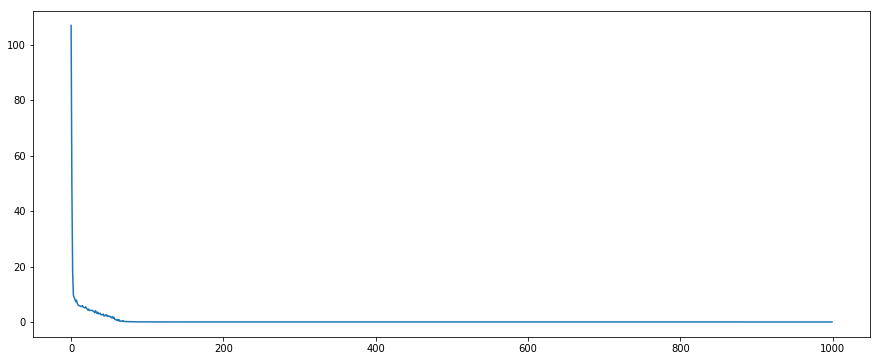

In [206]:
plt.figure(figsize=(15,6))
plt.plot(all_cost)

In [207]:
predict_data_x = test_data_std[500:]
predict_data_y = test_data_y_org[500:]

In [208]:
predict_y = []
for sample, tgt in zip(predict_data_x, predict_data_y):
    pct = m.model_forward(sample)
    predict_y.append(pct)

In [209]:
metrics.confusion_matrix(predict_data_y, [1 if pct > 0.5 else 0 for pct in predict_y])

array([[17,  0],
       [ 2, 50]], dtype=int64)

In [210]:
all_cost[-1]

3.1067647858223854e-05